In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# split data

In [2]:
import os
import random
from glob import glob
import shutil
for path in ['training/cat', 'training/dog', 'validation/cat', 'validation/dog']:
    try:
        os.makedirs(path)
    except FileExistsError as e:
        map(os.remove, glob(path+'/*'))

random.seed(1024)
cats = glob('data/train/cat.*.jpg')
random.shuffle(cats)
for cat in cats[:1250]:
    shutil.copy(cat, 'validation/cat/')
for cat in cats[1250:]:
    shutil.copy(cat, 'training/cat/')
dogs = glob('data/train/dog.*.jpg')
random.shuffle(dogs)
for dog in dogs[:1250]:
    shutil.copy(dog, 'validation/dog/')
for dog in dogs[1250:]:
    shutil.copy(dog, 'training/dog/')

# batch generator

In [19]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from keras import backend as K
K.set_image_data_format('channels_first')

In [24]:
def get_batches(dirname, gen=ImageDataGenerator(), batch_size=32, shuffle=True, class_mode='categorical'):
    return gen.flow_from_directory(dirname, target_size=(224, 224), batch_size=batch_size, shuffle=shuffle, class_mode=class_mode)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}


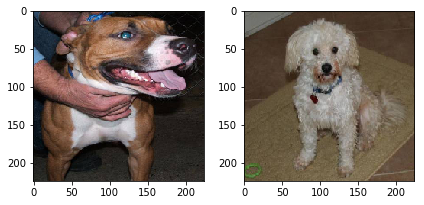

In [6]:
training_batches = get_batches('training')
validation_batches = get_batches('validation')
print(training_batches.class_indices)
print(validation_batches.class_indices)
imgs, labels = next(training_batches)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(np.rollaxis(imgs[0], 0, 3).astype(np.uint8))
ax2.imshow(np.rollaxis(imgs[1], 0, 3).astype(np.uint8))
plt.tight_layout()

# vgg16 model
http://files.fast.ai/models/vgg16.h5
* input_size = height x width x channels
* channel_order = bgr

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Lambda, Flatten, Dropout
from keras.layers.convolutional import ZeroPadding2D, Conv2D
from keras.layers.pooling import MaxPooling2D

In [8]:
VGG_MEAN = np.array([103, 116, 123]).reshape((3, 1, 1))
def preprocessing(img):
    #img = img - VGG_MEAN
    return img[::-1, :]
# imgs, labels = next(training_batches)
# img = imgs[0]
# print(img[:, 0, 0])
# img = preprocessing(img)
# print(img[:, 0, 0])

In [16]:
model = Sequential()
model.add(Lambda(preprocessing, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))
# Layer 1
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 2
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 3
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 4
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 5
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))
model.load_weights('vgg16.h5')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_29 (ZeroPaddi (None, 64, 114, 114)      0         
__________

# finetune

In [10]:
from keras.optimizers import Adam

In [17]:
for layer in model.layers:
    layer.trainable = False
model.pop()
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [18]:
model.fit_generator(training_batches,
                    steps_per_epoch=64,
                    epochs=10,
                    validation_data=validation_batches,
                    validation_steps=8)

Epoch 1/10
64/64 [==============================] - 46s - loss: 1.9157 - acc: 0.5044 - val_loss: 1.1439 - val_acc: 0.5117
Epoch 2/10
64/64 [==============================] - 46s - loss: 1.7040 - acc: 0.5034 - val_loss: 0.9500 - val_acc: 0.4844
Epoch 3/10
64/64 [==============================] - 46s - loss: 1.5517 - acc: 0.5000 - val_loss: 1.0306 - val_acc: 0.5039
Epoch 4/10
64/64 [==============================] - 46s - loss: 1.4141 - acc: 0.5073 - val_loss: 0.8912 - val_acc: 0.5044
Epoch 5/10
64/64 [==============================] - 46s - loss: 1.4568 - acc: 0.4990 - val_loss: 1.1395 - val_acc: 0.4609
Epoch 6/10
64/64 [==============================] - 46s - loss: 1.3830 - acc: 0.4995 - val_loss: 1.0360 - val_acc: 0.4961
Epoch 7/10
64/64 [==============================] - 46s - loss: 1.4034 - acc: 0.4907 - val_loss: 0.8912 - val_acc: 0.4961
Epoch 8/10
64/64 [==============================] - 46s - loss: 1.3297 - acc: 0.5087 - val_loss: 0.9204 - val_acc: 0.5234
Epoch 9/10
64/64 [======

# predict

In [35]:
test_batches = get_batches('test1', shuffle=False, batch_size=1, class_mode=None)
pred = model.predict_generator(test_batches, 12500, verbose=1)
filenames = test_batches.filenames

Found 12500 images belonging to 1 classes.
12500/12500 [==============================] - 432s   


In [37]:
isdog = pred[:,1]
isdog = isdog.clip(min=0.05, max=0.95)
ids = np.array([int(f[2:f.find('.')]) for f in filenames])
subm = np.stack([ids,isdog], axis=1)
np.savetxt('submission.csv', subm, fmt='%d,%.5f', header='id,label', comments='')